In [1]:
import sys
sys.path.insert(0, '/home/ading/dev/empirical-mt')

import matplotlib.pyplot as plt

from pelic.gabors import makeGabors, makeGaussian
from pelic.calculate_contrast import CalculateContrast

import pandas as pd

from tqdm import tqdm 

from tuning import DirectionTuning, SpeedTuning, DisparityTuning

import numpy as np

from skimage import io, transform, util
from skimage.color import rgb2gray, gray2rgb
from skimage.transform import resize
import skimage.draw as draw

import scipy.io as sio

import MT

from keras.layers import Input, Dense, Concatenate, Multiply
from keras.models import Model

size_ = 101
gabors = makeGabors(size_, center=None)
gaussian = makeGaussian(size_, sigma=5, center=None)

contrast_calculator = CalculateContrast(gabors, gaussian)

import tensorflow as tf

from os import listdir
from os.path import isfile, join, split, isdir, basename

from scipy import stats

Using TensorFlow backend.


In [5]:
df = pd.read_json('../data/alov300++/pairwise_train.json')

In [6]:
df.head()

,category,f1_ann,f1_filepath,f2_ann,f2_filepath,index,video_name,video_path
0,confusion,"[[77, 378], [288, 286]]",input/ALOV300++/imagedata++/09-Confusion/09-Co...,"[[90, 354], [301, 263]]",input/ALOV300++/imagedata++/09-Confusion/09-Co...,3392,09-Confusion_video00035,input/ALOV300++/imagedata++/09-Confusion/09-Co...
1,longduration,"[[399, 1239], [661, 1136]]",input/ALOV300++/imagedata++/14-LongDuration/14...,"[[399, 1239], [661, 1136]]",input/ALOV300++/imagedata++/14-LongDuration/14...,998,14-LongDuration_video00007,input/ALOV300++/imagedata++/14-LongDuration/14...
2,occlusion,"[[184, 1015], [996, 632]]",input/ALOV300++/imagedata++/11-Occlusion/11-Oc...,"[[167, 1029], [979, 646]]",input/ALOV300++/imagedata++/11-Occlusion/11-Oc...,13982,11-Occlusion_video00018,input/ALOV300++/imagedata++/11-Occlusion/11-Oc...
3,specularity,"[[60, 66], [107, 85]]",input/ALOV300++/imagedata++/03-Specularity/03-...,"[[61, 71], [108, 91]]",input/ALOV300++/imagedata++/03-Specularity/03-...,13855,03-Specularity_video00003,input/ALOV300++/imagedata++/03-Specularity/03-...
4,longduration,"[[103, 233], [139, 180]]",input/ALOV300++/imagedata++/14-LongDuration/14...,"[[104, 234], [140, 181]]",input/ALOV300++/imagedata++/14-LongDuration/14...,11980,14-LongDuration_video00003,input/ALOV300++/imagedata++/14-LongDuration/14...


In [7]:
def compute_box1_x(f1_ann):
    v1, v3 = f1_ann
    return np.abs(v1[1] - v3[1])

def compute_box1_y(f1_ann):
    v1, v3 = f1_ann
    return np.abs(v1[0] - v3[0])

df['box1_x'] = df['f1_ann'].map(compute_box1_x)
df['box1_y'] = df['f1_ann'].map(compute_box1_y)

In [9]:
df['box1_x'].describe()

count    11625.000000
mean       128.285849
std        138.047615
min         10.000000
25%         47.000000
50%         79.000000
75%        155.000000
max       1209.000000
Name: box1_x, dtype: float64

In [14]:
np.percentile(df['box1_x'], 80)

197.0

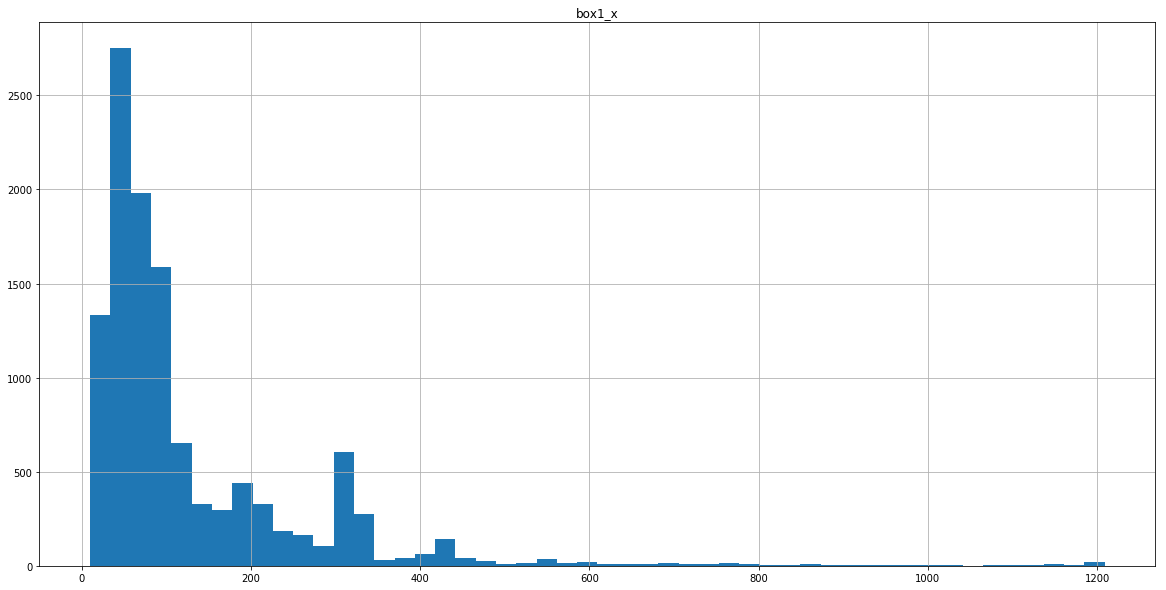

In [8]:
#plt.figure(figsize=(20, 20))


df.hist('box1_x', bins=50, figsize=(20, 10))

plt.show()

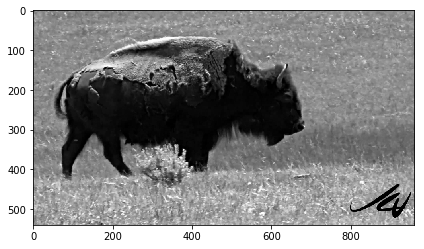

In [84]:
f = io.imread(join('../', df.loc[df['box1_x'] >= 1200].iloc[0]['f1_filepath']), as_gray=True)



f = transform.rescale(f, 0.5)


io.imshow(f)

plt.show()

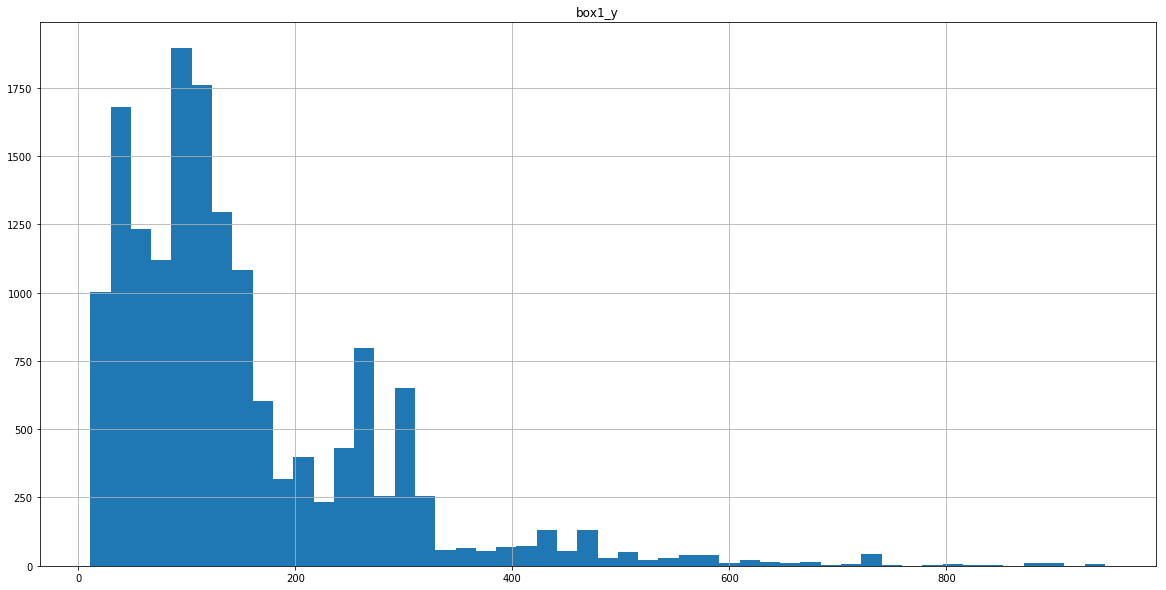

In [19]:
df.hist('box1_y',  bins=50, figsize=(20, 10))

plt.show()

In [90]:
np.median(np.append(df['box1_x'].values, df['box1_y'].values))

99.0

In [91]:
np.average(np.append(df['box1_x'].values, df['box1_y'].values))

138.98761155838483

In [92]:
stats.mode(np.append(df['box1_x'].values, df['box1_y'].values))

ModeResult(mode=array([90]), count=array([693]))

In [93]:
df['box_ratio'] = df.apply(lambda r: r['box1_x'] * 1. / r['box1_y'], axis=1)

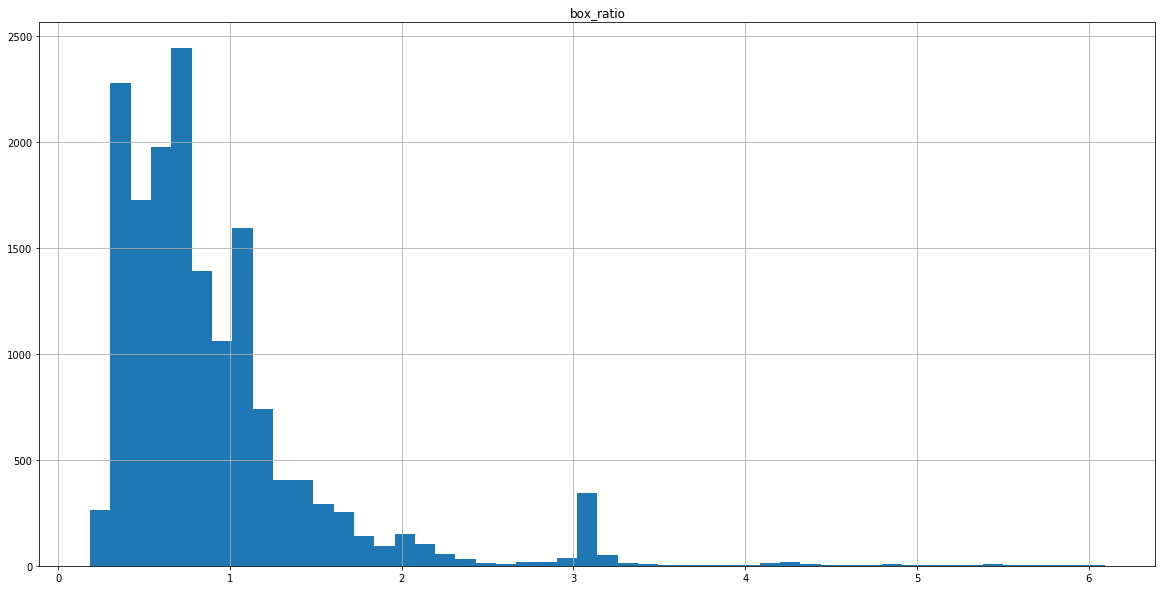

In [94]:
df.hist('box_ratio', bins=50, figsize=(20 ,10))

plt.show()

In [36]:
gt = pd.read_json('../data/alov300++/ground_truth/01-Light_video00001.ann')

In [37]:
gt.head()

,frame_id,v1,v2,v3,v4
1,1,"[188, 1080]","[188, 1013]","[270, 1013]","[270, 1080]"
11,11,"[167, 1088]","[167, 1021]","[249, 1021]","[249, 1088]"
16,16,"[178, 1035]","[178, 967]","[259, 967]","[259, 1035]"
21,21,"[186, 987]","[186, 920]","[267, 920]","[267, 987]"
26,26,"[192, 946]","[192, 878]","[274, 878]","[274, 946]"


In [11]:
df.head()

,category,f1_ann,f1_filepath,f2_ann,f2_filepath,video_name,video_path,box1_size,box1_x,box1_y
0,light,"[[188, 1080], [270, 1013]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[175, 1107], [257, 1040]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,5494,67,82
1,light,"[[175, 1107], [257, 1040]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[167, 1088], [249, 1021]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,5494,67,82
2,light,"[[167, 1088], [249, 1021]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[178, 1035], [259, 967]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,5494,67,82
3,light,"[[178, 1035], [259, 967]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[186, 987], [267, 920]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,5508,68,81
4,light,"[[186, 987], [267, 920]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[192, 946], [274, 878]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,5427,67,81


In [43]:
r = df.iloc[0]

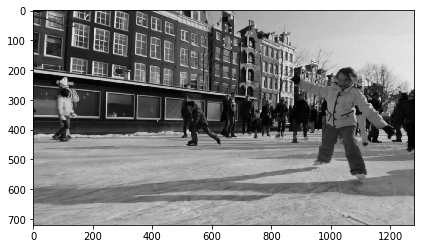

In [64]:
f1 = io.imread(join('../', r['f1_filepath']), as_gray=True)
f2 = io.imread(join('../', r['f2_filepath']), as_gray=True)

io.imshow(f1)
plt.show()

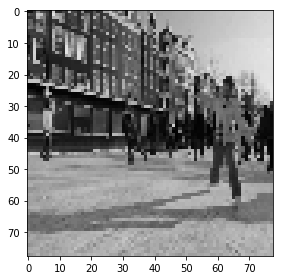

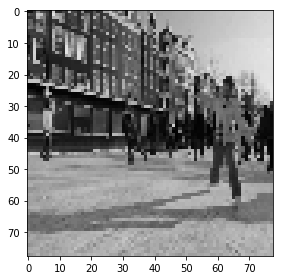

In [100]:
f1 = resize(f1, (78, 78))

io.imshow(f1)

plt.show()

io.imshow(f2)

plt.show()

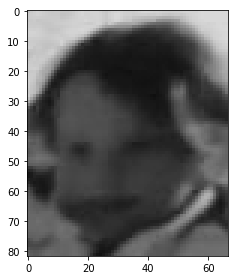

In [45]:
v1, v3 = r['f1_ann']

object_patch = f1[v1[0]:v3[0], v1[1]:v3[1]]

io.imshow(search_patch)
plt.show()

In [52]:
c_r, c_c = np.round(((v3[0] + v1[0]) / 2., (v3[1] + v1[1]) / 2.)).astype(np.int)

In [57]:
c_c

1046

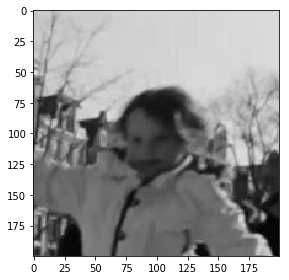

In [66]:
rr, cc = draw.rectangle(((c_r - 100), (c_c - 100)), extent=(200, 200), shape=f1.shape)

search_patch = f1[rr, cc].T

io.imshow(search_patch)
plt.show()

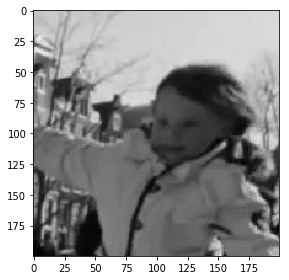

In [68]:
rr, cc = draw.rectangle(((c_r - 100), (c_c - 100)), extent=(200, 200), shape=f1.shape)

search_patch = f2[rr, cc].T

io.imshow(search_patch)
plt.show()

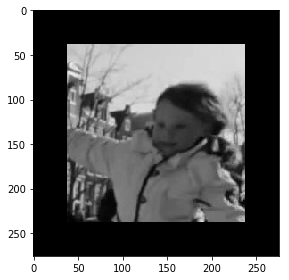

In [106]:
search_patch = util.pad(search_patch, ((38, 38), (38, 38)), mode='constant')

io.imshow(search_patch)
plt.show()

In [175]:
def _rescale_on_bounding_box(f1, box1, box2=None):
    box1_start, box1_end = box1
    box1_h, box1_w = box1_end - box1_start
    
    # caculate the scale
    f1_scale = 38. / max(box1_h, box1_w)
    
    # rescale the frame
    f1_rescaled = transform.rescale(f1, f1_scale)
    
    # print(f1_rescaled.shape)
    #f1_padded = util.pad(f1_rescaled, ((38, 38), (38, 38)), mode='constant')
    
    # caculate the bounding box after rescaling
    box1_rescaled = np.array((box1_start * f1_scale, box1_end * f1_scale)).astype(np.int) # + 38
    
    if box2 is None:
        return f1_rescaled, box1_rescaled
    
    box2_start, box2_end = box2
    box2_rescaled = np.array((box2_start * f1_scale, box2_end * f1_scale)).astype(np.int)
    
    return f1_rescaled, box1_rescaled, box2_rescaled


def _center_on_bounding_box_and_crop(frame, bounding_box, bounding_box2=None):
    # padded the frame
    frame = util.pad(frame, ((38, 38), (38, 38)), mode='constant')
    bounding_box = bounding_box + 38
    
    v1, v3 = bounding_box
    c_r, c_c = np.round((v1 + v3) / 2.).astype(np.int)
    
    rr, cc = draw.rectangle(((c_r - 38), (c_c - 38)), extent=(78, 78))
    
    centered_frame = frame[rr, cc].T
    
    v1_prime = np.array([37, 37], dtype=np.int) - ((v3 - v1) / 2)
    v3_prime = np.array([37, 37], dtype=np.int) + ((v3 - v1) / 2)
    
    if bounding_box2 is None:
        return centered_frame, (v1_prime, v3_prime)
    
    box2_v1, box2_v3 = bounding_box2 + 38
    
    box2_v1_prime = v1_prime + (box2_v1 - v1)
    box2_v3_prime = v3_prime + (box2_v3 - v3)
    
    print('%s,%s' % (v1_prime, v3_prime))
    print('%s, %s' % (box2_v1_prime, box2_v3_prime))
    
    return centered_frame, (v1_prime, v3_prime), (box2_v1_prime, box2_v3_prime)
    
    

def _parse(f1, f2, box1, box2):
    box1_start, box1_end = box1
    box1_h, box1_w = (box1_end[0] - box1_start[0]), (box1_end[1] - box1_start[1])
    
    box2_start, box2_end = box2
    #box2_h, box2_w = (box2_end[0] - box2_start[0]), (box1_end[1] - box1_start[1])
    
    f1_rescaled, box1_rescaled = _rescale_on_bounding_box(f1, box1)
    f2_rescaled, box1_rescaled, box2_rescaled = _rescale_on_bounding_box(f2, box1, box2)
    
    # box1_start_rescaled, box1_end_rescaled = box1_rescaled
    # rr, cc = draw.rectangle(box1_start_rescaled, box1_end_rescaled)
    
    #object_patch = f1_padded[rr, cc]
    f1_centered, box1_centered = _center_on_bounding_box_and_crop(f1_rescaled, box1_rescaled)
    
    f2_centered, _, box2_centered = _center_on_bounding_box_and_crop(f1_rescaled, box1_rescaled, box2_rescaled)
    
    return f1_centered, box1_centered, f2_centered, box2_centered

In [123]:
df.shape

(16023, 10)

[18 22],[56 52]
[12 34], [50 65]


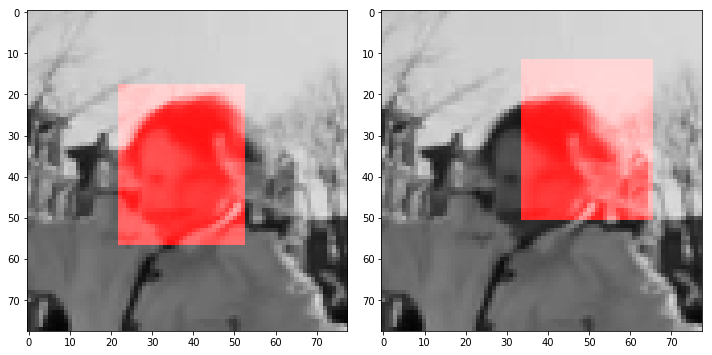

In [179]:
for index, r in df.iloc[[0]].iterrows():
    plt.figure(figsize=(10, 10))
    
    f1 = io.imread(join('../', r['f1_filepath']), as_gray=True)
    f2 = io.imread(join('../', r['f2_filepath']), as_gray=True)
    
    f1_ann = np.array(r['f1_ann'])
    f2_ann = np.array(r['f2_ann'])
    
    f1, box1, f2, box2 = _parse(f1, f2, f1_ann, f2_ann)
    
    # object patch
    plt.subplot(1, 2, 1)
    f1 = gray2rgb(f1)
    rr, cc = draw.rectangle(box1[0], box1[1])
    f1[rr, cc, 0] = 1
    io.imshow(f1)
    
    # search patch
    plt.subplot(1, 2, 2)
    
    f2 = gray2rgb(f2)
    rr, cc = draw.rectangle(box2[0], box2[1])
    f2[rr, cc, 0] = 1
    io.imshow(f2)
    
    
    # object patch
    #plt.subplot(1, 3, 3)
    #io.imshow(f2.T)
    
    plt.show()
    

In [187]:
np.max([1,2,3])

3

In [305]:
fixed_size = 200
ratio = 0.5


def _rescale_on_bounding_box(f1_ann, f2_ann):
    v1, v3 = _bounding_box_map_to_coord(f1_ann[:, :, 1])
    
    box_size = np.max(np.abs(v1 - v3))
    
    scale = fixed_size * ratio / box_size
    
    f1_ann_rescaled = transform.rescale(f1_ann, scale)
    f2_ann_resaled = transform.rescale(f2_ann, scale)

    return f1_ann_rescaled, f2_ann_resaled


def _bounding_box_map_to_coord(box):
    ann_coords = tuple(zip(*np.nonzero(box[:, :] >= 0.5)))
    return np.array((ann_coords[0], ann_coords[-1]))

    
def _center_on_bounding_box_and_crop(f1_ann, f2_ann):
    f1_ann_padded = util.pad(f1_ann, ((fixed_size, fixed_size), (fixed_size, fixed_size), (0, 0)), mode='constant')
    f2_ann_padded = util.pad(f2_ann, ((fixed_size, fixed_size), (fixed_size, fixed_size), (0, 0)), mode='constant')
    
    f1_box_v1, f1_box_v3 = _bounding_box_map_to_coord(f1_ann_padded[:, :, 1])
    f1_center = (f1_box_v1 + f1_box_v3) / 2
    
    f1_cropped_start = f1_center - (fixed_size / 2)
    f1_cropped_end = f1_center + (fixed_size / 2)
    
    #io.imshow(f1_ann_padded[:, :, 0])
    #plt.show()
    
    rr, cc = draw.rectangle(f1_cropped_start, f1_cropped_end)
    
    #print(f1_cropped_start)
    #print(f1_cropped_end)
    
    f1_cropped = f1_ann_padded[rr, cc, :]
    #f1_cropped = np.flip(f1_cropped, 1)
    #f1_cropped = np.flip(f1_cropped, 1)
    f1_cropped = np.fliplr(f1_cropped)
    #f1_cropped = np.flipud(f1_cropped)
    f1_cropped = transform.rotate(f1_cropped, 90)
    
    f2_cropped = f2_ann_padded[rr, cc, :]
    f2_cropped = np.fliplr(f2_cropped)
    f2_cropped = transform.rotate(f2_cropped, 90)
    #f2_cropped = np.flip(f2_cropped, 1)
    
    
    return f1_cropped, f2_cropped
    
    
def _annotate_frame(frame, box):
    annotated = np.zeros(frame.shape + (2, ))
    annotated[:, :, 0] = frame
    rr, cc = draw.rectangle(box[0], box[1])
    annotated[rr, cc, 1] = 1
    return annotated


def _parse(f1, f2, box1, box2):
    f1_ann = _annotate_frame(f1, box1 - 1)
    f2_ann = _annotate_frame(f2, box2 - 1)
    
    f1_ann_rescaled, f2_ann_rescaled = _rescale_on_bounding_box(f1_ann, f2_ann)
    f1_ann_centered, f2_ann_centered = _center_on_bounding_box_and_crop(f1_ann_rescaled, f2_ann_rescaled)
    
    f1_cropped = f1_ann_centered[:, :, 0]
    box1_cropped = _bounding_box_map_to_coord(f1_ann_centered[:, :, 1])
    
    f2_cropped = f2_ann_centered[:, :, 0]
    box2_cropped = _bounding_box_map_to_coord(f2_ann_centered[:, :, 1])
    
    return f1_cropped, f2_cropped, box1_cropped, box2_cropped

input/ALOV300++/imagedata++/04-Transparency/04-Transparency_video00013/00000044.jpg


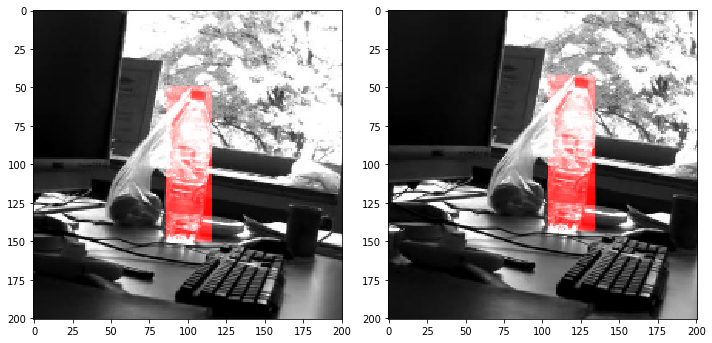

input/ALOV300++/imagedata++/11-Occlusion/11-Occlusion_video00015/00000215.jpg


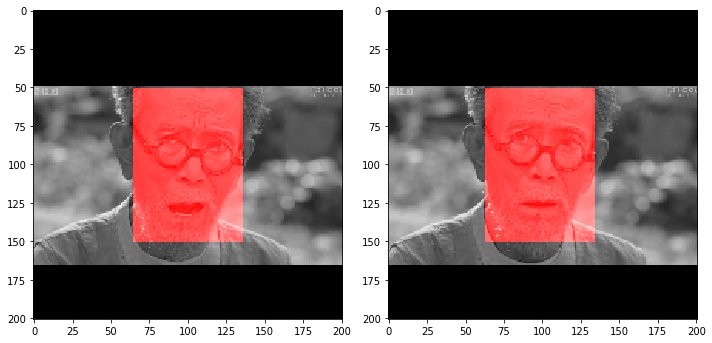

input/ALOV300++/imagedata++/10-LowContrast/10-LowContrast_video00018/00000056.jpg


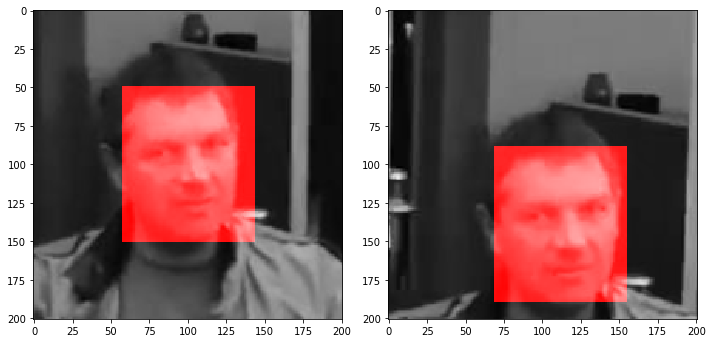

input/ALOV300++/imagedata++/01-Light/01-Light_video00031/00000064.jpg


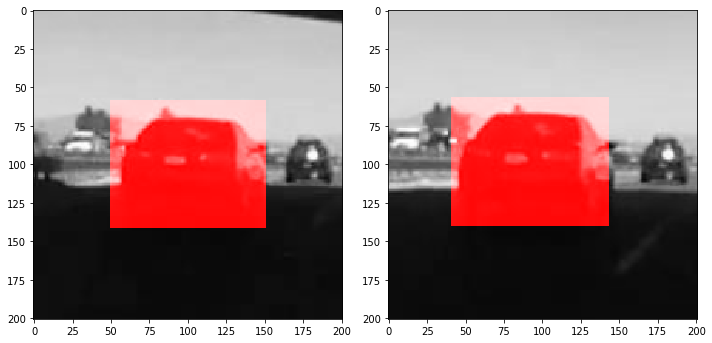

input/ALOV300++/imagedata++/01-Light/01-Light_video00030/00000146.jpg


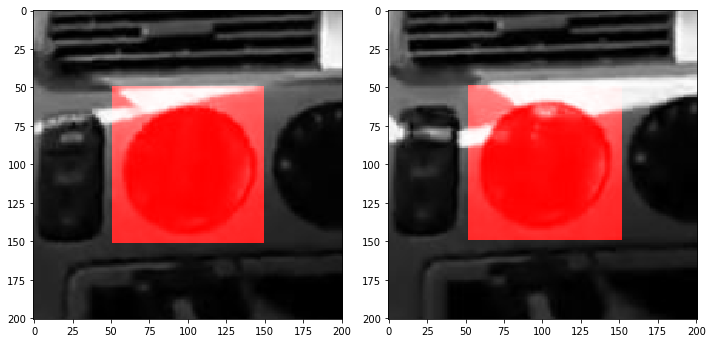

input/ALOV300++/imagedata++/01-Light/01-Light_video00010/00000095.jpg


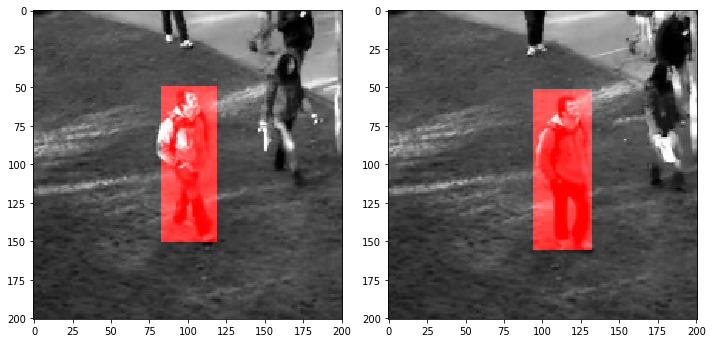

input/ALOV300++/imagedata++/14-LongDuration/14-LongDuration_video00007/00000511.jpg


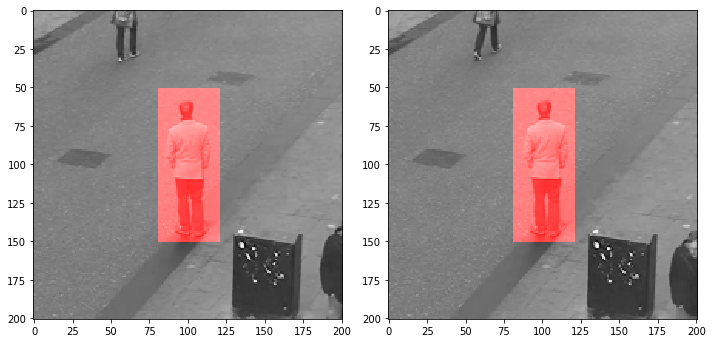

input/ALOV300++/imagedata++/14-LongDuration/14-LongDuration_video00008/00000746.jpg


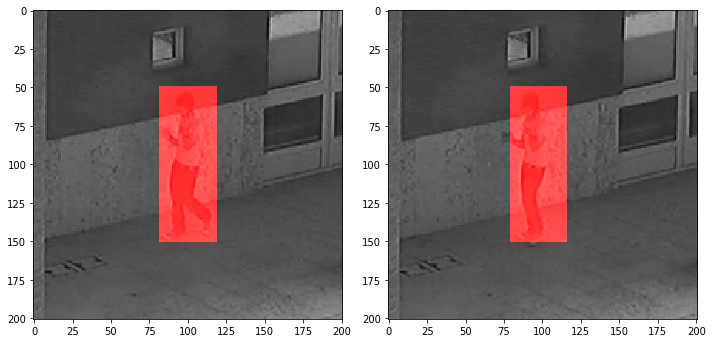

input/ALOV300++/imagedata++/02-SurfaceCover/02-SurfaceCover_video00011/00000275.jpg


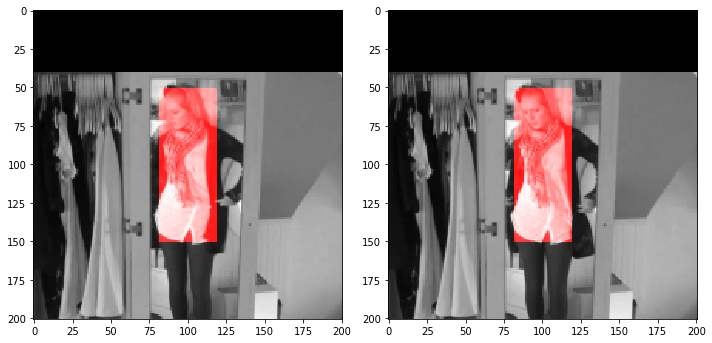

input/ALOV300++/imagedata++/13-ZoomingCamera/13-ZoomingCamera_video00009/00000016.jpg


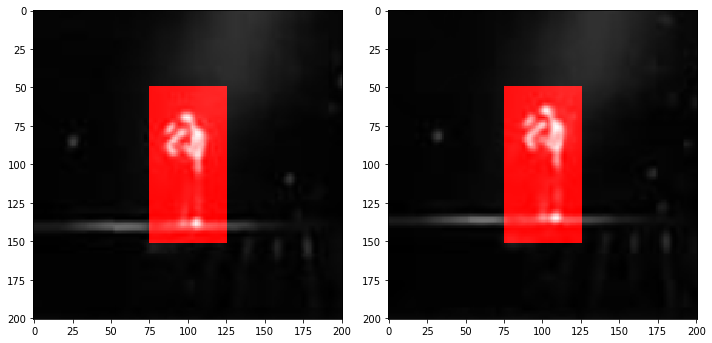

input/ALOV300++/imagedata++/10-LowContrast/10-LowContrast_video00022/00000048.jpg


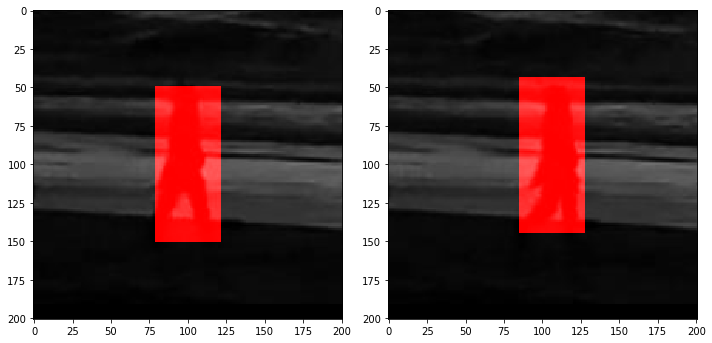

input/ALOV300++/imagedata++/01-Light/01-Light_video00002/00000101.jpg


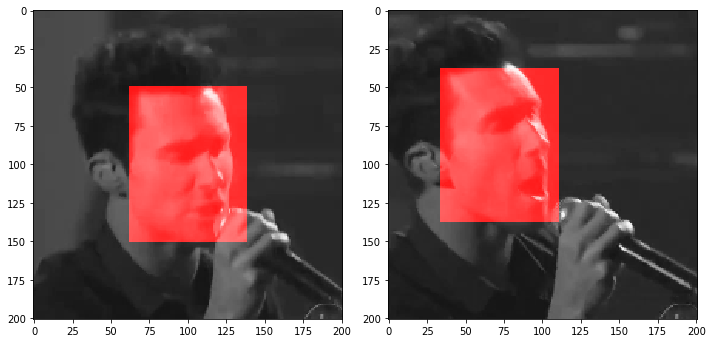

input/ALOV300++/imagedata++/11-Occlusion/11-Occlusion_video00015/00000593.jpg


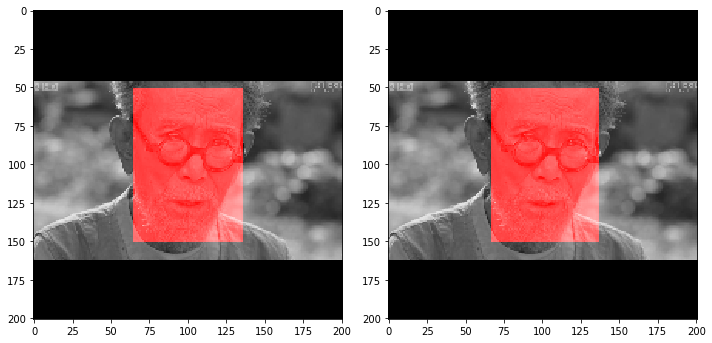

input/ALOV300++/imagedata++/14-LongDuration/14-LongDuration_video00003/00001514.jpg


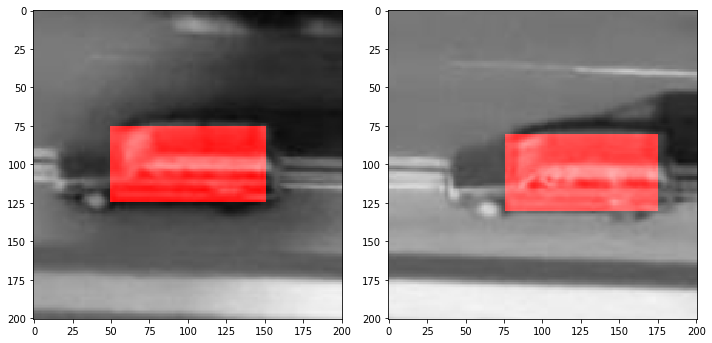

input/ALOV300++/imagedata++/14-LongDuration/14-LongDuration_video00008/00000886.jpg


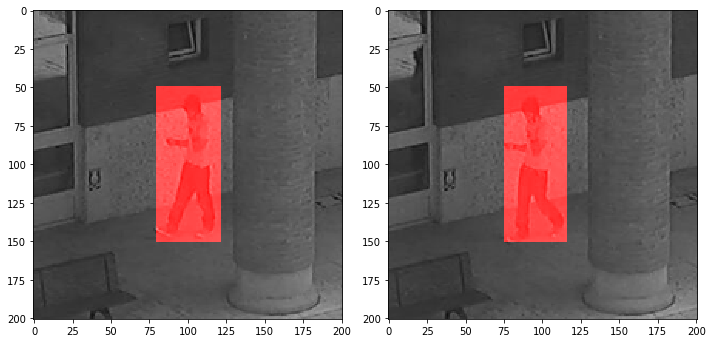

input/ALOV300++/imagedata++/14-LongDuration/14-LongDuration_video00002/00003085.jpg


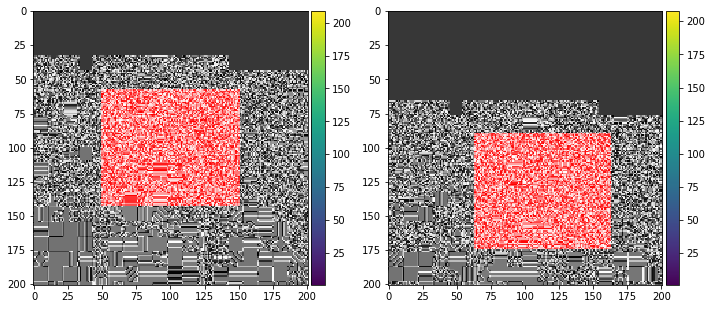

input/ALOV300++/imagedata++/01-Light/01-Light_video00030/00000176.jpg


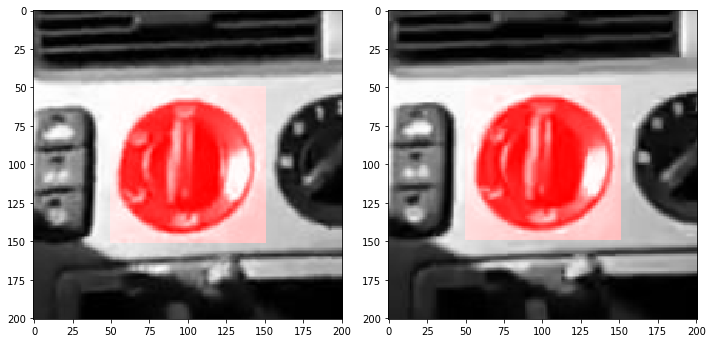

input/ALOV300++/imagedata++/07-MotionCoherence/07-MotionCoherence_video00011/00000098.jpg


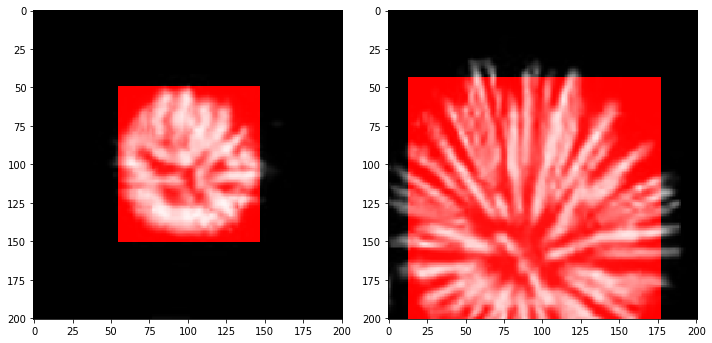

input/ALOV300++/imagedata++/12-MovingCamera/12-MovingCamera_video00005/00000228.jpg


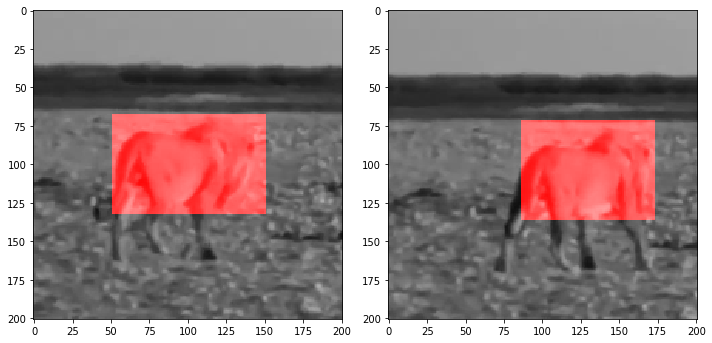

input/ALOV300++/imagedata++/09-Confusion/09-Confusion_video00033/00000249.jpg


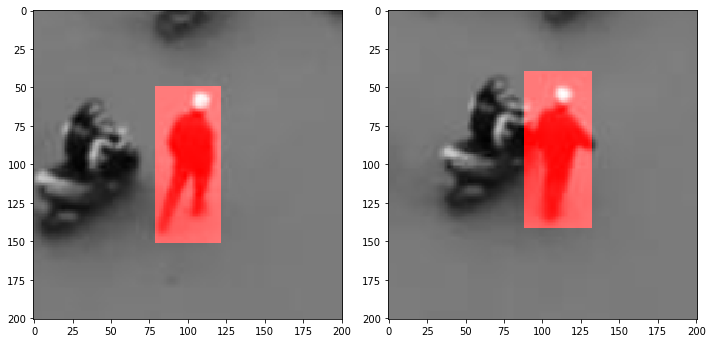

In [307]:
for index, r in df.sample(20).iterrows():
    plt.figure(figsize=(10, 10))
    
    f1 = io.imread(join('../', r['f1_filepath']), as_gray=True)
    f2 = io.imread(join('../', r['f2_filepath']), as_gray=True)
    
    f1_ann = np.array(r['f1_ann'])
    f2_ann = np.array(r['f2_ann'])
    
    f1, f2, box1, box2 = _parse(f1, f2, f1_ann, f2_ann)
    
    print(r['f1_filepath'])
    
    # object patch
    plt.subplot(1, 2, 1)
    f1 = gray2rgb(f1)
    rr, cc = draw.rectangle(box1[0], box1[1])
    f1[rr, cc, 0] = 1
    #f1 = transform.rotate(f1, 90)
    #f1 = np.flip(f1, 0)
    io.imshow(f1)
    
    # search patch
    plt.subplot(1, 2, 2)
    
    f2 = gray2rgb(f2)
    rr, cc = draw.rectangle(box2[0], box2[1])
    f2[rr, cc, 0] = 1
    #2 = transform.rotate(f2, 90)
    io.imshow(f2)
    
    
    # object patch
    #plt.subplot(1, 3, 3)
    #io.imshow(f2.T)
    
    plt.show()

In [315]:
img_as_uint16
io.imsave('../data/alov300++/tmp.png', f1[:, :, 0])

/home/ading/.local/lib/python2.7/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


In [321]:
from os import path

path.split(path.basename(df['f2_filepath'][0]))

(u'', u'00000006.jpg')

In [322]:
len(df)

16023

In [318]:
df.head()

,category,f1_ann,f1_filepath,f2_ann,f2_filepath,video_name,video_path,box1_x,box1_y,box_ratio
0,light,"[[188, 1013], [270, 1080]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[175, 1040], [257, 1107]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,67,82,0.817073
1,light,"[[175, 1040], [257, 1107]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[167, 1021], [249, 1088]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,67,82,0.817073
2,light,"[[167, 1021], [249, 1088]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[178, 967], [259, 1035]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,67,82,0.817073
3,light,"[[178, 967], [259, 1035]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[186, 920], [267, 987]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,68,81,0.839506
4,light,"[[186, 920], [267, 987]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,"[[192, 878], [274, 946]]",input/ALOV300++/imagedata++/01-Light/01-Light_...,01-Light_video00001,input/ALOV300++/imagedata++/01-Light/01-Light_...,67,81,0.827160


In [180]:
img = np.zeros((5,5))

rr, cc = draw.rectangle((1,1), (3,3))

img[rr, cc] = 1

In [185]:
img = np.zeros((5, 5, 2))

In [186]:
img[:, :, 1] = np.ones((5,5))

In [181]:
np.nonzero(img == 1)

(array([1, 1, 1, 2, 2, 2, 3, 3, 3]), array([1, 2, 3, 1, 2, 3, 1, 2, 3]))